In [60]:
import numpy as np
from stochastic.processes.continuous import FractionalBrownianMotion
# from stochastic.processes.noise import FractionalGaussianNoise
from scipy.special import gamma
import multiprocessing as mp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time


def GenerateNoise(H, t_fin, t_init, N, alpha, rng):
    '''the parameter rng produces unique series of random numbers at each simulation trajectory'''
    fbm = FractionalBrownianMotion(hurst=1-H, t=(t_fin - t_init), rng=rng)
    noise = np.sqrt(2 / gamma(1 + alpha)) * fbm.sample(N)
#     print(f"{noise[1]}\n")
    return noise

# def GenerateNoise(H, t_fin, t_init, N, alpha, rng):
#     fbm = FractionalBrownianMotion(hurst=1-H, t=(t_fin - t_init), rng=rng)
#     B = fbm.sample(N)
#     dB = np.diff(np.insert(B, 0, 0.0))

#     G = np.zeros(N)
#     for n in range(1, N):
#         weights = ( (n - np.arange(1, n+1) + 1)**alpha
#                     - (n - np.arange(1, n+1))**alpha )
#         G[n] = np.sum(weights * dB[1:n+1])
#     return G




def force_term(j, x):
    return x[j-1]


def approxfun(n, alpha, j, x):
    return float(force_term(j,x)*(((n-j+1)**alpha) - ((n-j) ** alpha)))


def simulate_process(args):
    H, t_fin, t_init, N, alpha, A, dt, r, xr, m, w, seed, i = args

    # random number generator with a unique seed
    rng = np.random.default_rng(seed)
    coefficient = (m*(w**2)*(dt**alpha))/(gamma(1+alpha))
    noise = GenerateNoise(H, t_fin, t_init, N, alpha, rng)

    # defining the position array
    x = np.zeros(N)
    xm = 0
    tr = 0
    reset_step = 1
    count = 0
    nn = []

    for n in range(1, N):
        r1 = rng.uniform(0, 1)
        if r1 < r * dt:
            x[n] = xr
            xm = xr
            reset_time = n*dt
            reset_step = n
            noise = GenerateNoise(H, t_fin, t_init+reset_time, N-reset_step, alpha, rng)
            count += 1
        else:
            x[n] = xm + x[0] + (-coefficient*sum(approxfun(n, alpha, j, x) for j in range(reset_step, n+1)) + noise[n-reset_step])/A
            # x[n] = xr + ( - coefficient * sum(approxfun(n, alpha, j, x) for j in range(reset_step, n+1))
              # + noise[n - reset_step] ) / A



    return x

if __name__ == "__main__":
    r = 10.0      # reset rate 
    xr = 0.0   # reset position 
    m = 1.0    # mass 
    w = 1.0    # barrier frequency 
    zeta = 1.0      # friction coefficient 
    H = 0.65        # Hurst index 
    N = 1000000       # simulation steps 
    nreps = 100   # number of simulations/trajectories 
    t_init = 0.0    # initial time 
    t_fin = 100.0   # final time 
    dt = (t_fin - t_init) / N   # time interval
    print(f'Time interval = {dt} sec.')
    alpha = 2-2*H
    A = 2*zeta*H*(2*H-1)*gamma(1-alpha)
    t1 = time.time()
    traj = np.zeros((nreps,N)) 
    
    with mp.Pool(processes=56) as pool:
        # Generate unique seeds for each process
        base_seed = int(time.time())
        seeds = [base_seed + i for i in range(nreps)]
        args = [(H, t_fin, t_init, N, alpha, A, dt, r, xr, m, w, seeds[i], i) for i in range(nreps)]
        trajs = pool.map(simulate_process, args)

    print(f"Simulation time = {(time.time() - t1)/60} min.")

Time interval = 0.0001 sec.
Simulation time = 46.736802403132124 min.


In [61]:
df = pd.DataFrame(trajs)
df

,0,1,2,3,4,5,6,7,8,9,...,999990,999991,999992,999993,999994,999995,999996,999997,999998,999999
0,0.0,0.0,-0.067556,-0.076120,-0.133021,-0.186609,-0.078434,-0.022838,-0.047879,-0.086740,...,-0.526770,-0.495805,-0.409508,-0.510599,-0.496685,-0.492978,-0.552674,-0.510376,-0.545185,-0.545776
1,0.0,0.0,-0.009625,0.051424,0.071887,0.040024,0.059815,0.030835,0.057674,0.048752,...,0.208122,0.212634,0.122371,0.153764,0.126264,0.122904,0.099494,0.088772,0.084621,0.148980
2,0.0,0.0,0.056057,0.071957,0.027310,-0.039660,0.041451,-0.051044,-0.109725,-0.094832,...,0.841924,0.847017,0.865735,0.826174,0.672406,0.663461,0.617597,0.700976,0.631312,0.614605
3,0.0,0.0,0.005071,-0.054600,-0.104506,-0.107725,-0.132466,-0.127117,-0.125783,-0.054983,...,0.210705,0.123973,0.186086,0.206404,0.159199,0.230292,0.162905,0.111542,0.135265,0.197110
4,0.0,0.0,-0.035434,-0.018579,-0.001301,0.083116,0.053604,0.048429,-0.070282,0.019219,...,0.549438,0.573216,0.490272,0.499773,0.361134,0.458919,0.497619,0.560129,0.517743,0.527126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,-0.123817,-0.151263,-0.216471,-0.131704,-0.104132,-0.205576,-0.161237,-0.215403,...,-0.050835,-0.093736,-0.064388,-0.064691,-0.133335,-0.096532,-0.177805,-0.128750,-0.116224,-0.090832
96,0.0,0.0,0.000655,0.064175,0.034022,0.015720,-0.089280,-0.133245,-0.042992,-0.013171,...,0.064594,0.178352,0.179274,0.227962,0.040491,0.130799,0.134292,0.048099,0.054765,-0.021433
97,0.0,0.0,0.036701,-0.015094,0.091166,0.092697,0.030756,0.052041,0.028555,0.055192,...,0.039814,0.007423,-0.042100,0.065779,0.106951,0.029457,0.050743,0.028944,-0.031973,0.015371
98,0.0,0.0,-0.047518,-0.055172,-0.031047,0.016515,0.055972,0.114664,0.108579,0.067230,...,0.265395,0.269686,0.322788,0.288100,0.265449,0.255150,0.268866,0.290516,0.235946,0.267334


In [46]:
# df.to_csv("trajs_r10_dt1e-5.csv")

In [62]:
df4 = df.drop(columns=[0])
df4

,1,2,3,4,5,6,7,8,9,10,...,999990,999991,999992,999993,999994,999995,999996,999997,999998,999999
0,0.0,-0.067556,-0.076120,-0.133021,-0.186609,-0.078434,-0.022838,-0.047879,-0.086740,-0.086084,...,-0.526770,-0.495805,-0.409508,-0.510599,-0.496685,-0.492978,-0.552674,-0.510376,-0.545185,-0.545776
1,0.0,-0.009625,0.051424,0.071887,0.040024,0.059815,0.030835,0.057674,0.048752,0.065690,...,0.208122,0.212634,0.122371,0.153764,0.126264,0.122904,0.099494,0.088772,0.084621,0.148980
2,0.0,0.056057,0.071957,0.027310,-0.039660,0.041451,-0.051044,-0.109725,-0.094832,-0.054792,...,0.841924,0.847017,0.865735,0.826174,0.672406,0.663461,0.617597,0.700976,0.631312,0.614605
3,0.0,0.005071,-0.054600,-0.104506,-0.107725,-0.132466,-0.127117,-0.125783,-0.054983,-0.127678,...,0.210705,0.123973,0.186086,0.206404,0.159199,0.230292,0.162905,0.111542,0.135265,0.197110
4,0.0,-0.035434,-0.018579,-0.001301,0.083116,0.053604,0.048429,-0.070282,0.019219,-0.075119,...,0.549438,0.573216,0.490272,0.499773,0.361134,0.458919,0.497619,0.560129,0.517743,0.527126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,-0.123817,-0.151263,-0.216471,-0.131704,-0.104132,-0.205576,-0.161237,-0.215403,-0.353460,...,-0.050835,-0.093736,-0.064388,-0.064691,-0.133335,-0.096532,-0.177805,-0.128750,-0.116224,-0.090832
96,0.0,0.000655,0.064175,0.034022,0.015720,-0.089280,-0.133245,-0.042992,-0.013171,-0.101288,...,0.064594,0.178352,0.179274,0.227962,0.040491,0.130799,0.134292,0.048099,0.054765,-0.021433
97,0.0,0.036701,-0.015094,0.091166,0.092697,0.030756,0.052041,0.028555,0.055192,0.112232,...,0.039814,0.007423,-0.042100,0.065779,0.106951,0.029457,0.050743,0.028944,-0.031973,0.015371
98,0.0,-0.047518,-0.055172,-0.031047,0.016515,0.055972,0.114664,0.108579,0.067230,0.044863,...,0.265395,0.269686,0.322788,0.288100,0.265449,0.255150,0.268866,0.290516,0.235946,0.267334


In [63]:
x_r10 = df4.to_numpy()

In [64]:
x_r10[0]

array([ 0.        , -0.06755595, -0.07612044, ..., -0.51037571,
       -0.54518538, -0.54577571])

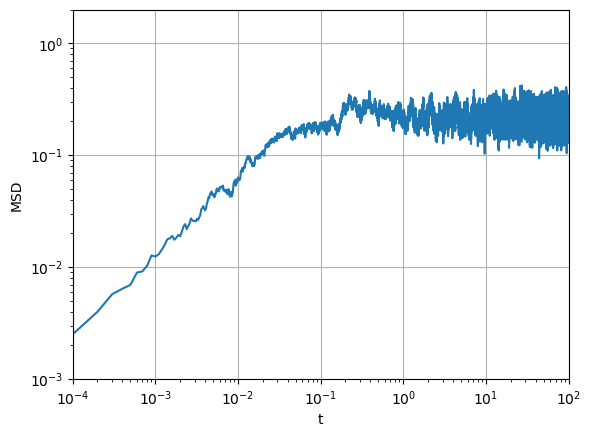

In [65]:
disp = x_r10 - x_r10[:, [0]]         

# MSD_r1 = np.mean(disp**2, axis=0)   # shape (N,)
MSD_r10 = np.mean(disp**2, axis=0)   # shape (N,)
# T_r10 = np.linspace(0,100,x_r10.shape[1])
dt = 100 / (x_r10.shape[1]-1)
T_r10 = np.arange(x_r10.shape[1]) * dt

plt.figure()
plt.plot(T_r10, MSD_r10)
plt.xlabel("t")
plt.ylabel("MSD")
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.0001,100)
plt.ylim(0.001,2)
plt.grid(True)
plt.show()

In [66]:
df_th = pd.read_csv("/home/debasish/Documents/resetting_fpt/msd/msd_with_resetting_omega_nonzero.csv", header=None)
df_th

,0,1,2,3,4,5
0,0.000010,0.000596,0.000596,0.000596,0.000596,0.000596
1,0.000013,0.000701,0.000701,0.000701,0.000701,0.000700
2,0.000016,0.000823,0.000823,0.000823,0.000823,0.000823
3,0.000020,0.000967,0.000967,0.000967,0.000967,0.000966
4,0.000025,0.001136,0.001136,0.001136,0.001136,0.001135
...,...,...,...,...,...,...
96,39810.717055,1.000000,0.933586,0.669071,0.000000,0.000000
97,50118.723363,1.000000,0.933586,0.669071,0.000000,0.000000
98,63095.734448,1.000000,0.933586,0.669071,0.000000,0.000000
99,79432.823472,1.000000,0.933586,0.669071,0.000000,0.000000


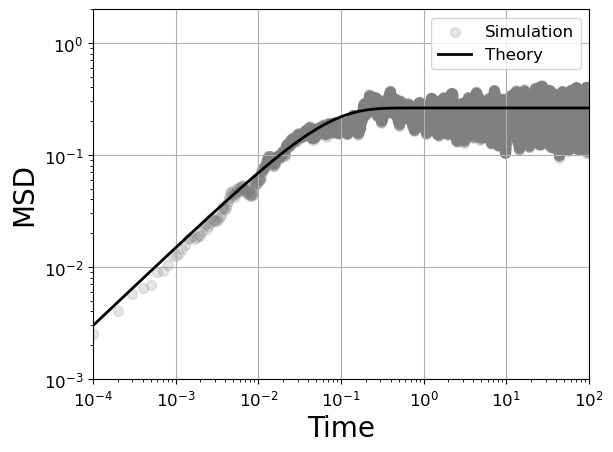

In [67]:
plt.scatter(T_r10[:], MSD_r10[:], alpha=0.2, s=50, color="gray", label="Simulation")
plt.plot(df_th[0], df_th[4], color='black', linewidth=2, label="Theory")

plt.xscale("log")
plt.yscale("log")
plt.xlim(0.0001,100)
plt.ylim(0.001,2)
plt.xlabel("Time", fontsize=20)
plt.ylabel("MSD", fontsize=20)
plt.tick_params(axis="both", labelsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()